# Overview
In this dataset, we are given images of human eyes and we are building a model that would predict whether the human eye image is **OPEN** or **CLOSED**. 

This is a binary classification problem as we only have $2$ target classes.

**Problem Statement**:
*Is the human eye on the image open or closed?*

# Ingest
We are given a directory containing images as the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
INPUT_DIR = "/kaggle/input/drowsiness-detection"
OUTPUT_DIR = "/kaggle/working/"
!tree -d /kaggle/input/drowsiness-detection

/kaggle/input/drowsiness-detection
├── closed_eye
└── open_eye

2 directories


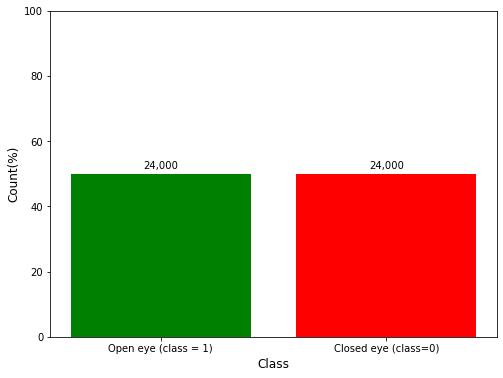

In [3]:
open_eye_count = len(next(os.walk(os.path.join(INPUT_DIR, "open_eye")))[2])
closed_eye_count = len(next(os.walk(os.path.join(INPUT_DIR, "closed_eye")))[2])

open_eye_percent = open_eye_count/(open_eye_count + closed_eye_count) * 100
closed_eye_percent = closed_eye_count/(open_eye_count + closed_eye_count) * 100

plt.figure(figsize=(8, 6))
rect1 = plt.bar(["Open eye (class = 1)"], [open_eye_percent], color="green")
plt.bar_label(rect1, [f"{open_eye_count:,d}"], padding=3)
rect2 = plt.bar(["Closed eye (class=0)"], [closed_eye_percent], color="red")
plt.bar_label(rect2, [f"{closed_eye_count:,d}"], padding=3)

plt.ylim(0, 100)
plt.ylabel("Count(%)", {"fontsize": 12})
plt.xlabel("Class", {"fontsize": 12})
plt.show()

🔑 The classes in the dataset are **balanced**. Each class is represented by $24,000$ images.

# Split training,validation, and test data
We're going to allocate $20\%$ of the original dataset as the *test set*.
The remaining $80\%$ will be divided as the *training set* ($70\%$) and the *validation set* ($30\%$).

**Summary**
* Total number of images: $48,000$
* Test set $(20\%)$ - $9,600$ images
* Training set $(56\%)$ - $26,880$ images
* Validation set $(24\%)$ - $11,520$ images

In [4]:
def split_dataset(parent_dir, target_dir):
    full_dir_path = os.path.join(parent_dir, target_dir)
    files = [filename for filename in os.listdir(full_dir_path)]
    files.sort()
    test_idx_limit, train_idx_limit = int(0.2 * len(files)), int((0.20 + 0.56) * len(files))
    np.random.seed(42)
    np.random.shuffle(files)
    
    test_files = files[:test_idx_limit]
    train_files = files[test_idx_limit: train_idx_limit]
    valid_files = files[train_idx_limit:]
    
    def move_files(src_dir, target_dir, files):
        for file in files:
            src_file = os.path.join(src_dir, file)
            dest_file = os.path.join(target_dir, file)
            shutil.copy(src_file, dest_file)
   

    TEST_DIR = os.path.join(OUTPUT_DIR, "test")
    if not os.path.exists(TEST_DIR):
        os.mkdir(TEST_DIR)
    TEST_TARGET_DIR = os.path.join(TEST_DIR, target_dir)
    if not os.path.exists(TEST_TARGET_DIR):
        os.mkdir(TEST_TARGET_DIR)
        print(f"Moving files to {TEST_TARGET_DIR}")
        move_files(full_dir_path, TEST_TARGET_DIR, test_files)
        
    TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
    if not os.path.exists(TRAIN_DIR):
        os.mkdir(TRAIN_DIR)
    TRAIN_TARGET_DIR = os.path.join(TRAIN_DIR, target_dir)
    if not os.path.exists(TRAIN_TARGET_DIR):
        os.mkdir(TRAIN_TARGET_DIR)
        print(f"Moving files to {TRAIN_TARGET_DIR}")
        move_files(full_dir_path, TRAIN_TARGET_DIR, train_files)
        
    VALID_DIR = os.path.join(OUTPUT_DIR, "valid")
    if not os.path.exists(VALID_DIR):
        os.mkdir(VALID_DIR)
    VALID_TARGET_DIR = os.path.join(VALID_DIR, target_dir)
    if not os.path.exists(VALID_TARGET_DIR):
        os.mkdir(VALID_TARGET_DIR)
        print(f"Moving files to {VALID_TARGET_DIR}")
        move_files(full_dir_path, VALID_TARGET_DIR, valid_files)
        
    return (TRAIN_TARGET_DIR, VALID_TARGET_DIR, TEST_TARGET_DIR)

split_dataset(INPUT_DIR, "open_eye")
split_dataset(INPUT_DIR, "closed_eye")

Moving files to /kaggle/working/test/open_eye
Moving files to /kaggle/working/train/open_eye
Moving files to /kaggle/working/valid/open_eye
Moving files to /kaggle/working/test/closed_eye
Moving files to /kaggle/working/train/closed_eye
Moving files to /kaggle/working/valid/closed_eye


('/kaggle/working/train/closed_eye',
 '/kaggle/working/valid/closed_eye',
 '/kaggle/working/test/closed_eye')

In [5]:
# !rm -Rf /kaggle/working/test
# !rm -Rf /kaggle/working/train
# !rm -Rf /kaggle/working/valid

# Exploratory Data Analysis

Found 26880 images belonging to 2 classes.
Found 11520 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


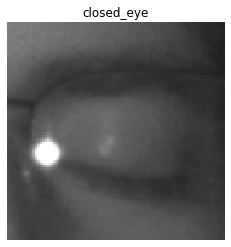

In [6]:
CLASSES = ["closed_eye", "open_eye"]
IMG_TARGET_SIZE = (224, 224)

TRAIN_DIR = "/kaggle/working/train"
train_img_gen = ImageDataGenerator(rescale=1./255)
train_data = train_img_gen.flow_from_directory(TRAIN_DIR,
                                               target_size=IMG_TARGET_SIZE,
                                               batch_size=32,
                                               classes=CLASSES,
                                               class_mode="binary")

VALID_DIR = "/kaggle/working/valid"
valid_img_gen = ImageDataGenerator(rescale=1./255)
valid_data = valid_img_gen.flow_from_directory(VALID_DIR,
                                               target_size=IMG_TARGET_SIZE,
                                               batch_size=32,
                                               classes=CLASSES,
                                               class_mode="binary")

TEST_DIR = "/kaggle/working/test"
test_img_gen = ImageDataGenerator(rescale=1./255)
test_data = test_img_gen.flow_from_directory(TEST_DIR,
                                               target_size=IMG_TARGET_SIZE,
                                               batch_size=32,
                                               classes=CLASSES,
                                               class_mode="binary")

plt.title(CLASSES[int(train_data[0][1][0])])
plt.imshow(train_data[0][0][0])
plt.axis("off")
plt.show()

# Build the model

## Baseline model - simple neural network

We start with a baseline model of ANN with $1$ hidden layer consisting of $10$ dense units. The output is then flattened out and passed to the final layer for binary classification.

In [7]:
tf.random.set_seed(42)

baseline_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu",
                          input_shape=(IMG_TARGET_SIZE[0], IMG_TARGET_SIZE[1], 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

baseline_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

baseline_history = baseline_model.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=valid_data,
                                      validation_steps=len(valid_data))

2023-02-07 15:01:15.889223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 15:01:15.995054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 15:01:15.995979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-07 15:01:15.997299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/5
840/840 [==============================] - 60s 69ms/step - loss: 0.4089 - accuracy: 0.8770 - val_loss: 0.2730 - val_accuracy: 0.9115
Epoch 2/5
840/840 [==============================] - 57s 68ms/step - loss: 0.2709 - accuracy: 0.9083 - val_loss: 0.2356 - val_accuracy: 0.9226
Epoch 3/5
840/840 [==============================] - 54s 65ms/step - loss: 0.2230 - accuracy: 0.9213 - val_loss: 0.2427 - val_accuracy: 0.9089
Epoch 4/5
840/840 [==============================] - 55s 66ms/step - loss: 0.2066 - accuracy: 0.9255 - val_loss: 0.2378 - val_accuracy: 0.9215
Epoch 5/5
840/840 [==============================] - 62s 74ms/step - loss: 0.1854 - accuracy: 0.9320 - val_loss: 0.1814 - val_accuracy: 0.9353


In [8]:
tf.random.set_seed(42)

baseline_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu",
                          input_shape=(IMG_TARGET_SIZE[0], IMG_TARGET_SIZE[1], 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

baseline_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

baseline_history = baseline_model.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=valid_data,
                                      validation_steps=len(valid_data))

Epoch 1/5
840/840 [==============================] - 58s 69ms/step - loss: 0.4242 - accuracy: 0.8712 - val_loss: 0.3203 - val_accuracy: 0.8965
Epoch 2/5
840/840 [==============================] - 56s 66ms/step - loss: 0.2643 - accuracy: 0.9093 - val_loss: 0.2202 - val_accuracy: 0.9273
Epoch 3/5
840/840 [==============================] - 56s 66ms/step - loss: 0.2092 - accuracy: 0.9249 - val_loss: 0.2088 - val_accuracy: 0.9284
Epoch 4/5
840/840 [==============================] - 60s 71ms/step - loss: 0.1895 - accuracy: 0.9308 - val_loss: 0.3087 - val_accuracy: 0.8881
Epoch 5/5
840/840 [==============================] - 57s 68ms/step - loss: 0.1972 - accuracy: 0.9309 - val_loss: 0.1714 - val_accuracy: 0.9406


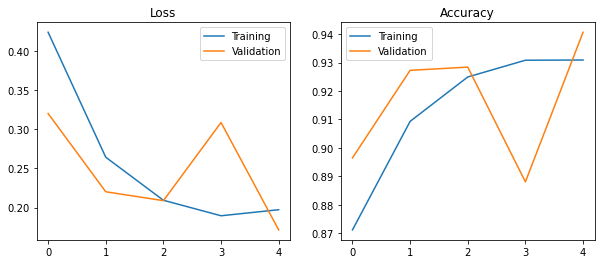

In [9]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    axs[0].plot(history['loss'], label="Training")
    axs[0].plot(history['val_loss'], label="Validation")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    axs[1].plot(history['accuracy'], label="Training")
    axs[1].plot(history['val_accuracy'], label="Validation")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    plt.show()

plot_history(baseline_history.history)

In [10]:
loss_baseline, accuracy_baseline = baseline_model.evaluate(test_data, verbose=0)

print(f"Baseline loss:{loss_baseline:.2f}")
print(f"Baseline accuracy:{accuracy_baseline*100:.2f}%")

Baseline loss:0.16
Baseline accuracy:94.57%


## Convolutional Neural Network (CNN)

In [11]:
tf.random.set_seed(42)

cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, 3, 
                           input_shape=(IMG_TARGET_SIZE[0], IMG_TARGET_SIZE[1], 3),
                          activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

cnn_model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

cnn1_history = cnn_model1.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=valid_data,
                              validation_steps=len(valid_data))

Epoch 1/5


2023-02-07 15:11:29.156508: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


840/840 [==============================] - 61s 65ms/step - loss: 0.2394 - accuracy: 0.8994 - val_loss: 0.2000 - val_accuracy: 0.9269
Epoch 2/5
840/840 [==============================] - 51s 61ms/step - loss: 0.1376 - accuracy: 0.9538 - val_loss: 0.1743 - val_accuracy: 0.9415
Epoch 3/5
840/840 [==============================] - 56s 66ms/step - loss: 0.1187 - accuracy: 0.9605 - val_loss: 0.1055 - val_accuracy: 0.9636
Epoch 4/5
840/840 [==============================] - 51s 61ms/step - loss: 0.1134 - accuracy: 0.9613 - val_loss: 0.1132 - val_accuracy: 0.9643
Epoch 5/5
840/840 [==============================] - 54s 64ms/step - loss: 0.1100 - accuracy: 0.9636 - val_loss: 0.1107 - val_accuracy: 0.9641


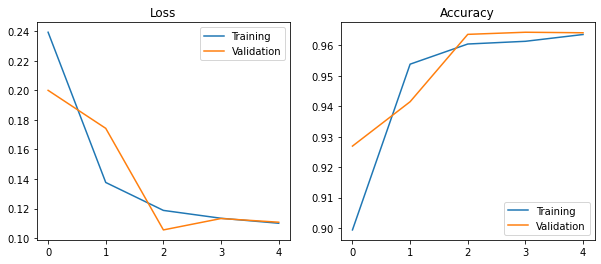

In [12]:
plot_history(cnn1_history.history)

In [13]:
cnn_model1.evaluate(test_data)

300/300 [==============================] - 13s 44ms/step - loss: 0.1112 - accuracy: 0.9652


[0.11117734014987946, 0.9652083516120911]

# Conclusion

Either a simple neural network or a CNN work well in this datasetwith accuracy $> 90\%$.